# Imports

In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import utils
from sklearn.cluster import KMeans

# Read Data

In [2]:
mines_csv = pl.read_csv(
    r"C:\Users\16617\Desktop\Code_Library\DMR Analysis\DMR_All_Mines.csv",
    ignore_errors=True,
)

counties = geopandas.read_file(
    r"C:\Users\16617\Desktop\Code_Library\DMR Analysis\ca-county-boundaries\CA_Counties\CA_Counties_TIGER2016.shp"
)

# Clean and Filter Data

In [3]:
cols_to_keep = utils.get_cols_to_keep()

mines_csv = mines_csv[cols_to_keep]

active_open_pit_mines = mines_csv.filter(
    (pl.col("MineStatus").str.contains("ACTIVE"))
    & (pl.col("Opt_Type").str.contains("OPEN PIT"))
    & (~pl.col("PriProduct").str.contains("NOT REPORT"))
)

holloway = active_open_pit_mines.filter(pl.col("Operator").str.contains("HOLLOWAY"))

# Plot Data

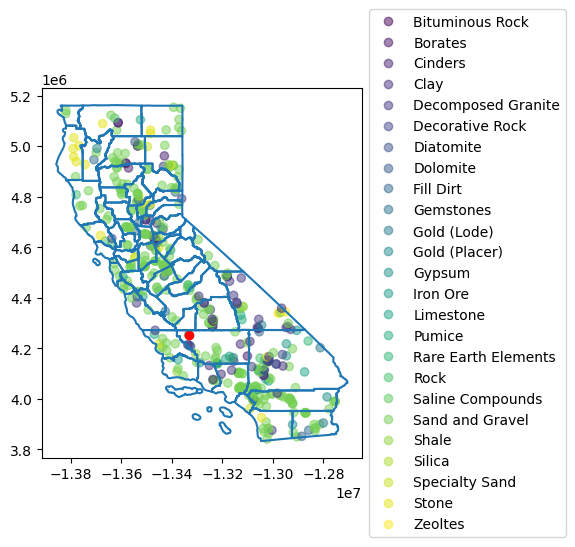

In [4]:
fig, ax = plt.subplots()

counties.boundary.plot(ax=ax)

sizes = (
    active_open_pit_mines.select(pl.col("FaceAmount")).fill_null(0).to_numpy().squeeze()
)
norm_sizes = 10000 * (sizes / np.linalg.norm(sizes))
labels, index = np.unique(
    active_open_pit_mines.select(pl.col("PriProduct")).to_numpy().squeeze(),
    return_inverse=True,
)

sc = ax.scatter(
    active_open_pit_mines["X"],
    active_open_pit_mines["Y"],
    c=index,
    alpha=0.5,
)
plt.scatter(holloway["X"], holloway["Y"], c="red", label="Holloway")
ax.legend(
    sc.legend_elements(num=None)[0], labels, loc="center left", bbox_to_anchor=(1, 0.5)
)
plt.show()

In [19]:
data_for_k_means = active_open_pit_mines.drop_nulls()
kmeans = KMeans(n_clusters=8, random_state=0, n_init="auto")
data_for_k_means = data_for_k_means.with_columns(pl.Series(name="cluster",values=kmeans.fit_predict(data_for_k_means.select(["Acres_Dist","FaceAmount"]).to_numpy())))

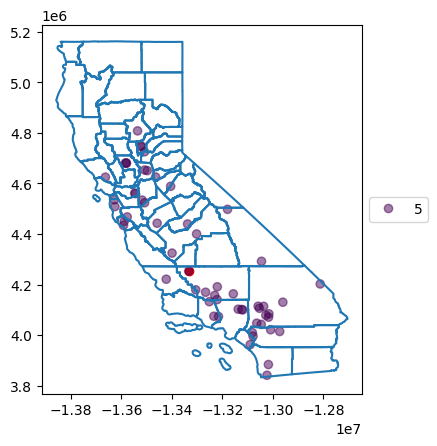

In [22]:
fig, ax = plt.subplots()
cluster_9 = data_for_k_means.filter(pl.col("cluster")==5)
counties.boundary.plot(ax=ax)
labels, index = np.unique(
    cluster_9.select(pl.col("cluster")).to_numpy().squeeze(),
    return_inverse=True,
)
plt.scatter(holloway["X"], holloway["Y"], c="red", label="Holloway")
sc = ax.scatter(
    cluster_9["X"],
    cluster_9["Y"],
    c=index,
    alpha=0.5,
)
ax.legend(
    sc.legend_elements(num=None)[0], labels, loc="center left", bbox_to_anchor=(1, 0.5)
)
plt.show()

In [21]:
data_for_k_means.filter(pl.col("Operator").str.contains("HOLLOWAY"))

Mine_ID,MineName,X,Y,Latitude,Longitude,ReportYear,Acres_Dist,MineStatus,Operator,Opt_City,Owner,PriProduct,Opt_Type,FaceAmount,cluster
str,str,f64,f64,f64,f64,i64,f64,str,str,str,str,str,str,f64,i32
"""91-15-0017""","""LOST HILLS MIN…",-1.3333e7,4.2533e6,35.655,-119.773056,2022,708.0,"""ACTIVE""","""H.M. HOLLOWAY""","""Bakersfield ""","""H.M. HOLLOWAY""","""Gypsum""","""OPEN PIT""",1.1266e6,5
